# Take Home Assignment

## Objectives:
1. Sample 10 code snippets from the task Code Clone Detection from the benchmark
CodeXGlue

2. Implement code for collecting the code embedding from an existing model CodeBERT
published on Hugging Face

3. Visualize the embedding by using TSNE technique in the library SciKit-Learn

4. Observe the result and summarize your findings (such as “Code X and Y are close to
each other in the vector space because they are sematically equivlant.“).

### Installing required libraries

In [1]:
!pip install transformers torch numpy scikit-learn matplotlib datasets tqdm 

### Importing required modules

In [2]:
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from datasets import load_dataset
import random
import math


/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading pretrained model, tokenizer and data

In [3]:
model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
data = load_dataset("code_x_glue_cc_clone_detection_big_clone_bench")

## Objective 1
### Selecting random 5 points from dataset

In [4]:
# random_indexs =random.sample(range(0, len(data['train'])), 5)
# print(random_indexs)
random_indexs = [37925, 300133, 339484, 282252, 435587]
for i in random_indexs:
  print(str(i) + ": "+ str(data['train'][i]['label']))

37925: True
300133: False
339484: True
282252: False
435587: True


In [5]:
code_snippets = []
for i in random_indexs:
  code_snippets.append(data['train'][i]['func1'])
  code_snippets.append(data['train'][i]['func2'])

code_snippets

['    private void appendArchive() throws Exception {\n        String cmd;\n        if (profile == CompilationProfile.UNIX_GCC) {\n            cmd = "cat";\n        } else if (profile == CompilationProfile.MINGW_WINDOWS) {\n            cmd = "type";\n        } else {\n            throw new Exception("Unknown cat equivalent for profile " + profile);\n        }\n        compFrame.writeLine("<span style=\'color: green;\'>" + cmd + " \\"" + imageArchive.getAbsolutePath() + "\\" >> \\"" + outputFile.getAbsolutePath() + "\\"</span>");\n        BufferedOutputStream out = new BufferedOutputStream(new FileOutputStream(outputFile, true));\n        BufferedInputStream in = new BufferedInputStream(new FileInputStream(imageArchive));\n        int read;\n        while ((read = in.read()) != -1) {\n            out.write(read);\n        }\n        in.close();\n        out.close();\n    }\n',
 '    public static File enregistrerFichier(String fileName, File file, String path, String fileMime) throws Ex

In [6]:
def tokenize_code_snippets(code_snippets):
    tokenized_code_snippets = []
    for code_snippet in code_snippets:
        tokenized_code_snippets.append(tokenizer.encode(code_snippet, max_length=512, truncation=True, padding='max_length'))
    return tokenized_code_snippets

tokenized_code_snippets = tokenize_code_snippets(code_snippets)
print(tokenized_code_snippets[0][:10])

[0, 1437, 1437, 1437, 940, 13842, 40462, 37848, 2088, 43048]


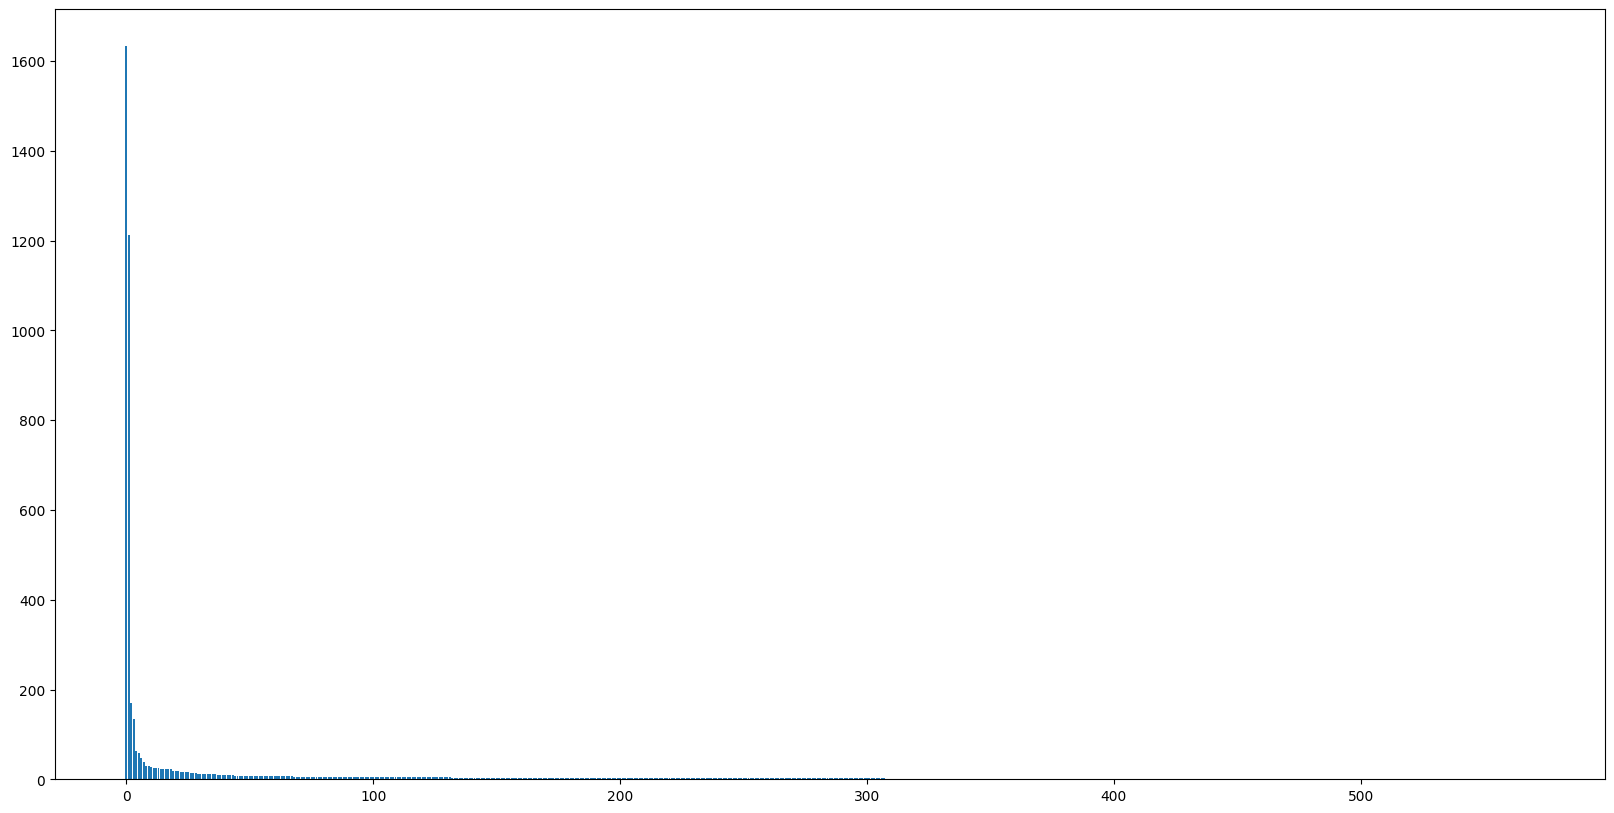

In [7]:
def plot_frequency_of_tokens(tokenized_code_snippets):
    token_frequency = {}
    for tokenized_code_snippet in tokenized_code_snippets:
        for token in tokenized_code_snippet:
            if token in token_frequency:
                token_frequency[token] += 1
            else:
                token_frequency[token] = 1
    plt.figure(figsize=(20, 10))
    plt.bar(range(len(token_frequency)), sorted(token_frequency.values(), reverse=True))
    plt.show()


plot_frequency_of_tokens(tokenized_code_snippets)

## Objective 2
### Getting emmbeddings from the model

In [8]:
def get_embeddings(tokenized_code_snippets):
    input_ids = torch.tensor(tokenized_code_snippets)
    with torch.no_grad():
        model_output = model(input_ids)
        embeddings = model_output.last_hidden_state[:,0,:].numpy()
    return embeddings

embeddings = get_embeddings(tokenized_code_snippets)
print(embeddings.shape)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


(10, 768)


In [9]:
def get_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=0, perplexity=8)
    X_2d = tsne.fit_transform(embeddings)
    return X_2d

X_2d = get_tsne(embeddings)
print(X_2d.shape)


(10, 2)


## Objective 3
### Visualizing the embeddings

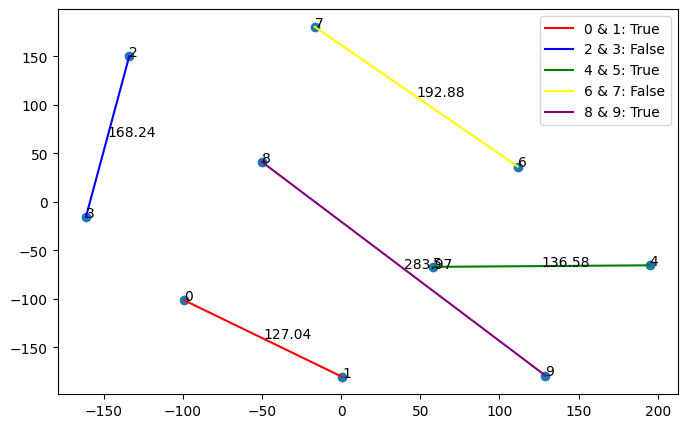

In [10]:
def plot_tsne(X_2d, code_snippets, colors):
    plt.figure(figsize=(8, 5))
    plt.scatter(X_2d[:,0], X_2d[:,1])

    for i in range(0, len(X_2d), 2):
        plt.plot(X_2d[i:i+2,0], X_2d[i:i+2,1], c=colors[math.floor(i/2)])
        dist = np.linalg.norm(X_2d[i] - X_2d[i+1])
        location = (X_2d[i] + X_2d[i+1]) / 2
        plt.annotate(str(round(dist, 2)), location)


    for i, txt in enumerate(code_snippets):
        plt.annotate(i, (X_2d[i,0], X_2d[i,1]))

    for i in range(0, len(X_2d), 2):
        plt.plot([], [], c=colors[math.floor(i/2)], label=str(i) + " & " + str(i+1) + ": "+ str(data['train'][random_indexs[math.floor(i/2)]]['label']))
    plt.legend()
    
    plt.show()

colors = ["red", "blue", "green", "yellow", "purple"]
    
plot_tsne(X_2d, code_snippets, colors)

## Objective 4
### Observations

1. Some points, like 0, 1, 4, and 5, are shown close together because they are syntactically similar in how they are written, therefore marked as "True." However, points 8 and 9 are far apart even though they are also marked as "True." This difference in distance might happen because when we truncate the code into pieces, we can only use a limited length of 512 characters. So, if there's more code than that, some parts might get cut off.

2. We can see that some points, like 2 and 3, seem close together on the graph even though they are marked as "False." This can also be because of the maximum length  during code tokenization. Sometimes, the beginning of two pieces of code might look similar, but the part that makes them different could be left out because it's too long, making them seem similar when they are not.